In this file it is mainly the evaluation of the KNN and its visualisation. Using the created files in step 6 but then just the code in here.

In [42]:
import os
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import faiss

In [ ]:
import os
import pandas as pd
import numpy as np
import faiss

# Parse descriptor columns
def parse_descriptor_columns(df):
    for col in ['A3', 'D1', 'D2', 'D3', 'D4']:
        df[col] = df[col].apply(lambda x: np.fromstring(x, sep=','))
    feature_matrix = np.hstack([    
        df['surfaceAreaObj'].values.reshape(-1, 1),
        df['compactnessObj'].values.reshape(-1, 1),
        df['rectangularityObj'].values.reshape(-1, 1),
        df['diameterObj'].values.reshape(-1, 1),
        df['convexityObj'].values.reshape(-1, 1),
        df['eccentricityObj'].values.reshape(-1, 1),
        np.vstack(df['A3'].values),
        np.vstack(df['D1'].values),
        np.vstack(df['D2'].values),
        np.vstack(df['D3'].values),
        np.vstack(df['D4'].values)
    ])
    return feature_matrix

# Load descriptors with parsed columns
def load_descriptors(csv_filepath):
    if os.path.exists(csv_filepath):
        print("File found! Loading...")
        df = pd.read_csv(csv_filepath)
        feature_matrix = parse_descriptor_columns(df)
        return df, feature_matrix
    else:
        print(f"File not found at: {csv_filepath}")
        return None, None

# FAISS-based KNN Engine for Evaluation
class KNNEvaluationEngine:
    def __init__(self, feature_dim):
        self.feature_dim = feature_dim
        self.index = faiss.IndexFlatL2(self.feature_dim)  # Initialize FAISS with L2 (Euclidean) distance

    def build_index(self, features):
        features = np.ascontiguousarray(features, dtype=np.float32)  # Ensure correct format
        self.index.add(features)  # Add features to the FAISS index

    def query(self, query_vector, k=7):
        query_vector = np.ascontiguousarray(query_vector.reshape(1, -1), dtype=np.float32)
        distances, indices = self.index.search(query_vector, k + 1)  # Search for k+1 neighbors to exclude self
        indices, distances = indices[0][1:k+1], distances[0][1:k+1]  # Exclude the query shape itself
        return indices, distances

# Calculate precision and recall
def calculate_precision_recall(df, knn_engine, feature_matrix, k=5):
    correct_matches = 0
    total_relevant = 0
    total_retrieved = 0
    precision_per_class = {}
    recall_per_class = {}
    class_counts = df['class'].value_counts().to_dict()

    for idx, query_shape in df.iterrows():
        query_vector = feature_matrix[idx]
        query_class = query_shape['class']
        
        # Retrieve k-nearest neighbors using FAISS
        neighbors, _ = knn_engine.query(query_vector, k=k)

        # Calculate true positives
        relevant_retrieved = sum(1 for neighbor_idx in neighbors if df.iloc[neighbor_idx]['class'] == query_class)
        total_relevant += sum(1 for _ in df[df['class'] == query_class].index)
        correct_matches += relevant_retrieved
        total_retrieved += k

        # Precision and Recall per class
        if query_class not in precision_per_class:
            precision_per_class[query_class] = []
            recall_per_class[query_class] = []
        
        precision = relevant_retrieved / k if k > 0 else 0
        recall = relevant_retrieved / total_relevant if total_relevant > 0 else 0

        precision_per_class[query_class].append(precision)
        recall_per_class[query_class].append(recall)

    # Calculate aggregate precision and recall for each class
    avg_precision_per_class = {cls: np.mean(precisions) for cls, precisions in precision_per_class.items()}
    avg_recall_per_class = {cls: np.mean(recalls) for cls, recalls in recall_per_class.items()}

    # Grand aggregate (overall precision and recall)
    overall_precision = correct_matches / total_retrieved if total_retrieved > 0 else 0
    overall_recall = correct_matches / total_relevant if total_relevant > 0 else 0

    return avg_precision_per_class, avg_recall_per_class, overall_precision, overall_recall, class_counts

def main():
    csv_filepath = r'dataBaseNormalised.csv'

    # Load the descriptors
    df, feature_matrix = load_descriptors(csv_filepath)
    if df is None or feature_matrix is None:
        print("Failed to load descriptors. Exiting.")
        return

    # Initialize and build the FAISS index
    knn_engine = KNNEvaluationEngine(feature_dim=feature_matrix.shape[1])
    knn_engine.build_index(feature_matrix)

    # Set K for KNN
    k = 5

    # Calculate precision and recall
    avg_precision_per_class, avg_recall_per_class, overall_precision, overall_recall, class_counts = calculate_precision_recall(df, knn_engine, feature_matrix, k=k)

    # Create a list to store the results
    results = []

    # Populate the list with class name, average precision, recall, and object count
    for cls in avg_precision_per_class.keys():
        results.append({
            'class': (cls,(class_counts[cls]*5)),
            'avg_precision': avg_precision_per_class[cls],
            'recall': avg_recall_per_class[cls]
        })

    # Display the results
    for result in results:
        print(f"Class {result['class']}: Precision = {result['avg_precision']:.5f}, Recall = {result['recall']:.5f}")

    # Print overall precision and recall
    print(f"\nOverall Precision: {overall_precision}")
    print(f"Overall Recall: {overall_recall}")
    return results

results = main()


File found! Loading...
Class ('AircraftBuoyant', 80): Precision = 0.02500, Recall = 0.00072
Class ('Apartment', 115): Precision = 0.09565, Recall = 0.00095
Class ('AquaticAnimal', 145): Precision = 0.15862, Recall = 0.00069
Class ('Bed', 135): Precision = 0.03704, Recall = 0.00009
Class ('Bicycle', 130): Precision = 0.43077, Recall = 0.00080
Class ('Biplane', 225): Precision = 0.36000, Recall = 0.00044
Class ('Bird', 220): Precision = 0.15909, Recall = 0.00013
Class ('Bookset', 100): Precision = 0.08000, Recall = 0.00006
Class ('Bottle', 155): Precision = 0.30968, Recall = 0.00020
Class ('BuildingNonResidential', 220): Precision = 0.05455, Recall = 0.00003
Class ('Bus', 100): Precision = 0.04000, Recall = 0.00002
Class ('Car', 445): Precision = 0.31461, Recall = 0.00011
Class ('Cellphone', 100): Precision = 0.47000, Recall = 0.00012
Class ('Chess', 210): Precision = 0.34286, Recall = 0.00009
Class ('City', 135): Precision = 0.14074, Recall = 0.00003
Class ('ClassicPiano', 100): Precisi

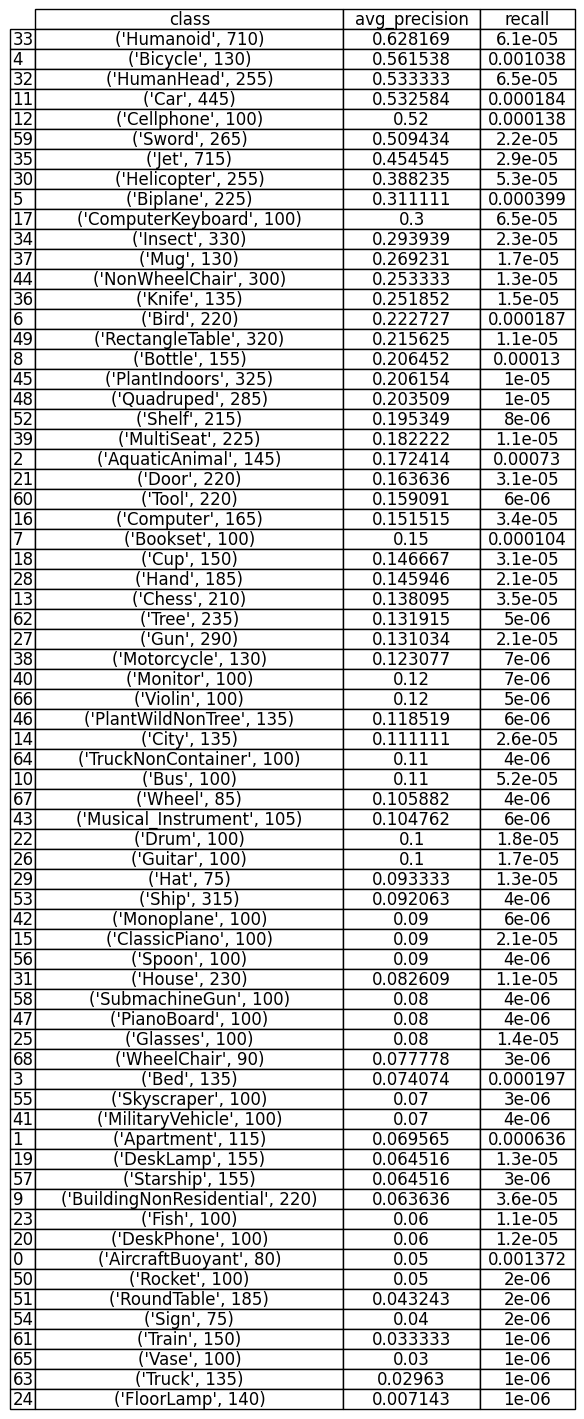

In [84]:
# Convert the list of dictionaries to a DataFrame
df = pd.DataFrame(results)

# Format the float values to 5 decimal places
df = df.round(6)
df = df.sort_values(by='avg_precision', ascending=False)
# Plot the table using matplotlib
fig, ax = plt.subplots()  # Set size frame
ax.axis('tight')
ax.axis('off')
table = pd.plotting.table(ax, df, loc='center', cellLoc='center', colWidths=[0.2]*len(df.columns))

table.auto_set_font_size(False)
table.set_fontsize(12)
table.scale(2.2, 1.2)

# Remove the index column
table.auto_set_column_width([0, 1, 2])
for key, cell in table.get_celld().items():
    if key[1] == -1:
        cell.visible = False

plt.show()

In [ ]:
import os
import pandas as pd
import numpy as np
import faiss
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
import matplotlib.cm as cm

class KNNEngine:
    def __init__(self, feature_dim):
        self.feature_dim = feature_dim
        self.index = faiss.IndexFlatL2(self.feature_dim)

    def build_index(self, features):
        features = np.ascontiguousarray(features, dtype=np.float32)
        self.index.add(features)

    def query(self, query_vector, k=5):
        query_vector = np.ascontiguousarray(query_vector.reshape(1, -1), dtype=np.float32)
        distances, indices = self.index.search(query_vector, k + 1)  
        indices, distances = indices[0][1:k+1], distances[0][1:k+1]  
        return indices, distances

class DimensionalityReducer:
    def __init__(self, features):
        self.features = features

    def apply_tsne(self):
        tsne = TSNE(n_components=2, perplexity=30, n_iter=1000, random_state=42)
        reduced_features = tsne.fit_transform(self.features)
        return reduced_features

def parse_descriptor_columns(df):
    for col in ['A3', 'D1', 'D2', 'D3', 'D4']:
        df[col] = df[col].apply(lambda x: np.fromstring(x, sep=','))

    feature_matrix = np.hstack([    
        df['surfaceAreaObj'].values.reshape(-1, 1),
        df['compactnessObj'].values.reshape(-1, 1),
        df['rectangularityObj'].values.reshape(-1, 1),
        df['diameterObj'].values.reshape(-1, 1),
        df['convexityObj'].values.reshape(-1, 1),
        df['eccentricityObj'].values.reshape(-1, 1),
        np.vstack(df['A3'].values),
        np.vstack(df['D1'].values),
        np.vstack(df['D2'].values),
        np.vstack(df['D3'].values),
        np.vstack(df['D4'].values)
    ])
    return feature_matrix

def load_descriptors(csv_filepath):
    if os.path.exists(csv_filepath):
        print("File found! Loading...")
        df = pd.read_csv(csv_filepath)
        feature_matrix = parse_descriptor_columns(df)
        return df, feature_matrix
    else:
        print(f"File not found at: {csv_filepath}")
        return None, None

def visualize_tsne_2d(reduced_features, labels, highlight_index=None, title="t-SNE Visualization"):
    plt.figure(figsize=(12, 8))
    
    # Generate a colormap with enough colors for all unique classes
    unique_labels = np.unique(labels)
    colors = cm.get_cmap("tab20", len(unique_labels))  # Use 'tab20' for up to 20 distinct colors

    # Plot each class with its color
    for idx, label in enumerate(unique_labels):
        indices = np.where(labels == label)
        plt.scatter(reduced_features[indices, 0], reduced_features[indices, 1], 
                    label=label, color=colors(idx), s=50, alpha=0.7)

    # Highlight the specific point if provided
    if highlight_index is not None:
        plt.scatter(reduced_features[highlight_index, 0], reduced_features[highlight_index, 1], 
                    color='red', s=100, edgecolor='black', label='Selected Shape', zorder=5)

    # Set titles and labels
    plt.title(title, fontsize=16)
    plt.xlabel('Component 1', fontsize=12)
    plt.ylabel('Component 2', fontsize=12)

    # Place legend outside the plot
    plt.legend(title="Class", bbox_to_anchor=(1.05, 1), loc='upper left', 
               borderaxespad=0., fontsize='small', ncol=2)
    plt.grid(True)
    plt.tight_layout()  # Adjust layout to fit everything nicely

    plt.show()

def select_shape_by_name(df, filePath):
    shape_name = filePath
    selected_shape_idx = df[df['name'].str.lower() == shape_name.lower()].index
    if len(selected_shape_idx) == 0:
        print("Shape not found!")
        return None
    return selected_shape_idx[0]

def methode(filePath):
    csv_filepath = r'dataBaseNormalised.csv'

    df, features = load_descriptors(csv_filepath)
    if df is None or features is None:
        print("Failed to load descriptors. Exiting.")
        return
    knn = KNNEngine(feature_dim=features.shape[1])
    knn.build_index(features)
    selected_shape_idx = select_shape_by_name(df, filePath)
    if selected_shape_idx is None:
        return
    query_vector = features[selected_shape_idx]
    k = 5
    neighbors, distances = knn.query(query_vector, k=k)
    print(f"Query shape: {df.iloc[selected_shape_idx]['name']}")
    print("K-Nearest Neighbors:")
    combined_array = []
    for i, neighbor_idx in enumerate(neighbors):
        shape_name = df.iloc[neighbor_idx]['name']
        shape_class = df.iloc[neighbor_idx]['class']
        combined_array.append([(f"{shape_class}/{shape_name}"), distances[i]])
        print(f"{i + 1}: Shape = {shape_name}, Class = {shape_class}, Distance = {distances[i]}")
    dr = DimensionalityReducer(features)
    reduced_features = dr.apply_tsne()
    labels = df['class'].values
    visualize_tsne_2d(reduced_features, labels, highlight_index=selected_shape_idx)  # Highlight the selected shape
    return combined_array


def perform_knn_for_all_objects(csv_filepath):
    df, features = load_descriptors(csv_filepath)
    
    if df is None or features is None:
        print("Failed to load descriptors. Exiting.")
        return
    
    # Initialize KNN engine with ANN using IVF indexing
    knn = KNNEngine(feature_dim=features.shape[1])
    knn.build_index(features)

    results_list = []

    for idx in range(len(df)):
        query_vector = features[idx]
        
        neighbors, distances = knn.query(query_vector)

        result_dict = {
            "object": df.iloc[idx]['name'],
            "class": df.iloc[idx]['class'],
            "neighbors": [df.iloc[n]['class'] for n in neighbors],
            "distances": distances.tolist(),
            "top_10_neighbors": [df.iloc[n]['class'] for n in neighbors[:10]]
        }
        
        results_list.append(result_dict)

    results_df = pd.DataFrame(results_list)
    
    return results_df

# Example usage:
csv_filepath = r'dataBaseNormalised.csv'
results_df = perform_knn_for_all_objects(csv_filepath)
results_df.head

File found! Loading...


<bound method NDFrame.head of           object            class  \
0      m1337.obj  AircraftBuoyant   
1      m1338.obj  AircraftBuoyant   
2      m1339.obj  AircraftBuoyant   
3      m1340.obj  AircraftBuoyant   
4      m1341.obj  AircraftBuoyant   
...          ...              ...   
2476   m1574.obj            Truck   
2477  D00499.obj       WheelChair   
2478  D00056.obj            Truck   
2479  D00526.obj       WheelChair   
2480  D00604.obj       WheelChair   

                                              neighbors  \
0     [HumanHead, HumanHead, HumanHead, HumanHead, V...   
1         [HumanHead, HumanHead, Vase, Cellphone, Hand]   
2                  [DeskLamp, Tree, Gun, Tree, Glasses]   
3               [Train, Knife, Tree, Spoon, PianoBoard]   
4               [HumanHead, Mug, Bird, Bird, HumanHead]   
...                                                 ...   
2476  [MultiSeat, Apartment, MultiSeat, PlantWildNon...   
2477  [TruckNonContainer, PlantIndoors, Humanoid, Tr.

In [61]:
results = results_df

In [62]:
# Assuming results_df is already available from the previous code

def count_top_10_neighbors(results_df):
    # Initialize an empty dictionary to store the counts
    class_counts = {}

    # Iterate over each unique class in the results_df
    for unique_class in results_df['class'].unique():
        # Filter the DataFrame for the current unique class
        class_df = results_df[results_df['class'] == unique_class]

        # Initialize a dictionary to store counts for the current unique class
        neighbor_counts = {}

        # Iterate over each row in the filtered DataFrame
        for _, row in class_df.iterrows():
            # Get the top 10 neighbors for the current object
            top_10_neighbors = row['top_10_neighbors']

            # Count the occurrences of each neighbor class
            for neighbor_class in top_10_neighbors:
                if neighbor_class in neighbor_counts:
                    neighbor_counts[neighbor_class] += 1
                else:
                    neighbor_counts[neighbor_class] = 1

        # Store the counts for the current unique class in the main dictionary
        class_counts[unique_class] = neighbor_counts

    # Convert the dictionary to a DataFrame for better readability
    counts_df = pd.DataFrame(class_counts).fillna(0).astype(int)

    return counts_df

# Example usage:
counts_df = count_top_10_neighbors(results)
print(counts_df)

                  AircraftBuoyant  Apartment  AquaticAnimal  Bed  Bicycle  \
HumanHead                      23          6              2    1        0   
House                           4         15              2    3        0   
Monitor                         2          2              0    2        2   
PlantWildNonTree                1          1              1    0        0   
PlantIndoors                    1          1              1    1        2   
...                           ...        ...            ...  ...      ...   
Truck                           0          0              0    1        1   
Bicycle                         0          0              0    2       73   
Biplane                         0          0              0    0       10   
Sword                           0          0              0    0        0   
Guitar                          0          0              0    0        0   

                  Biplane  Bird  Bookset  Bottle  BuildingNonResidential  .

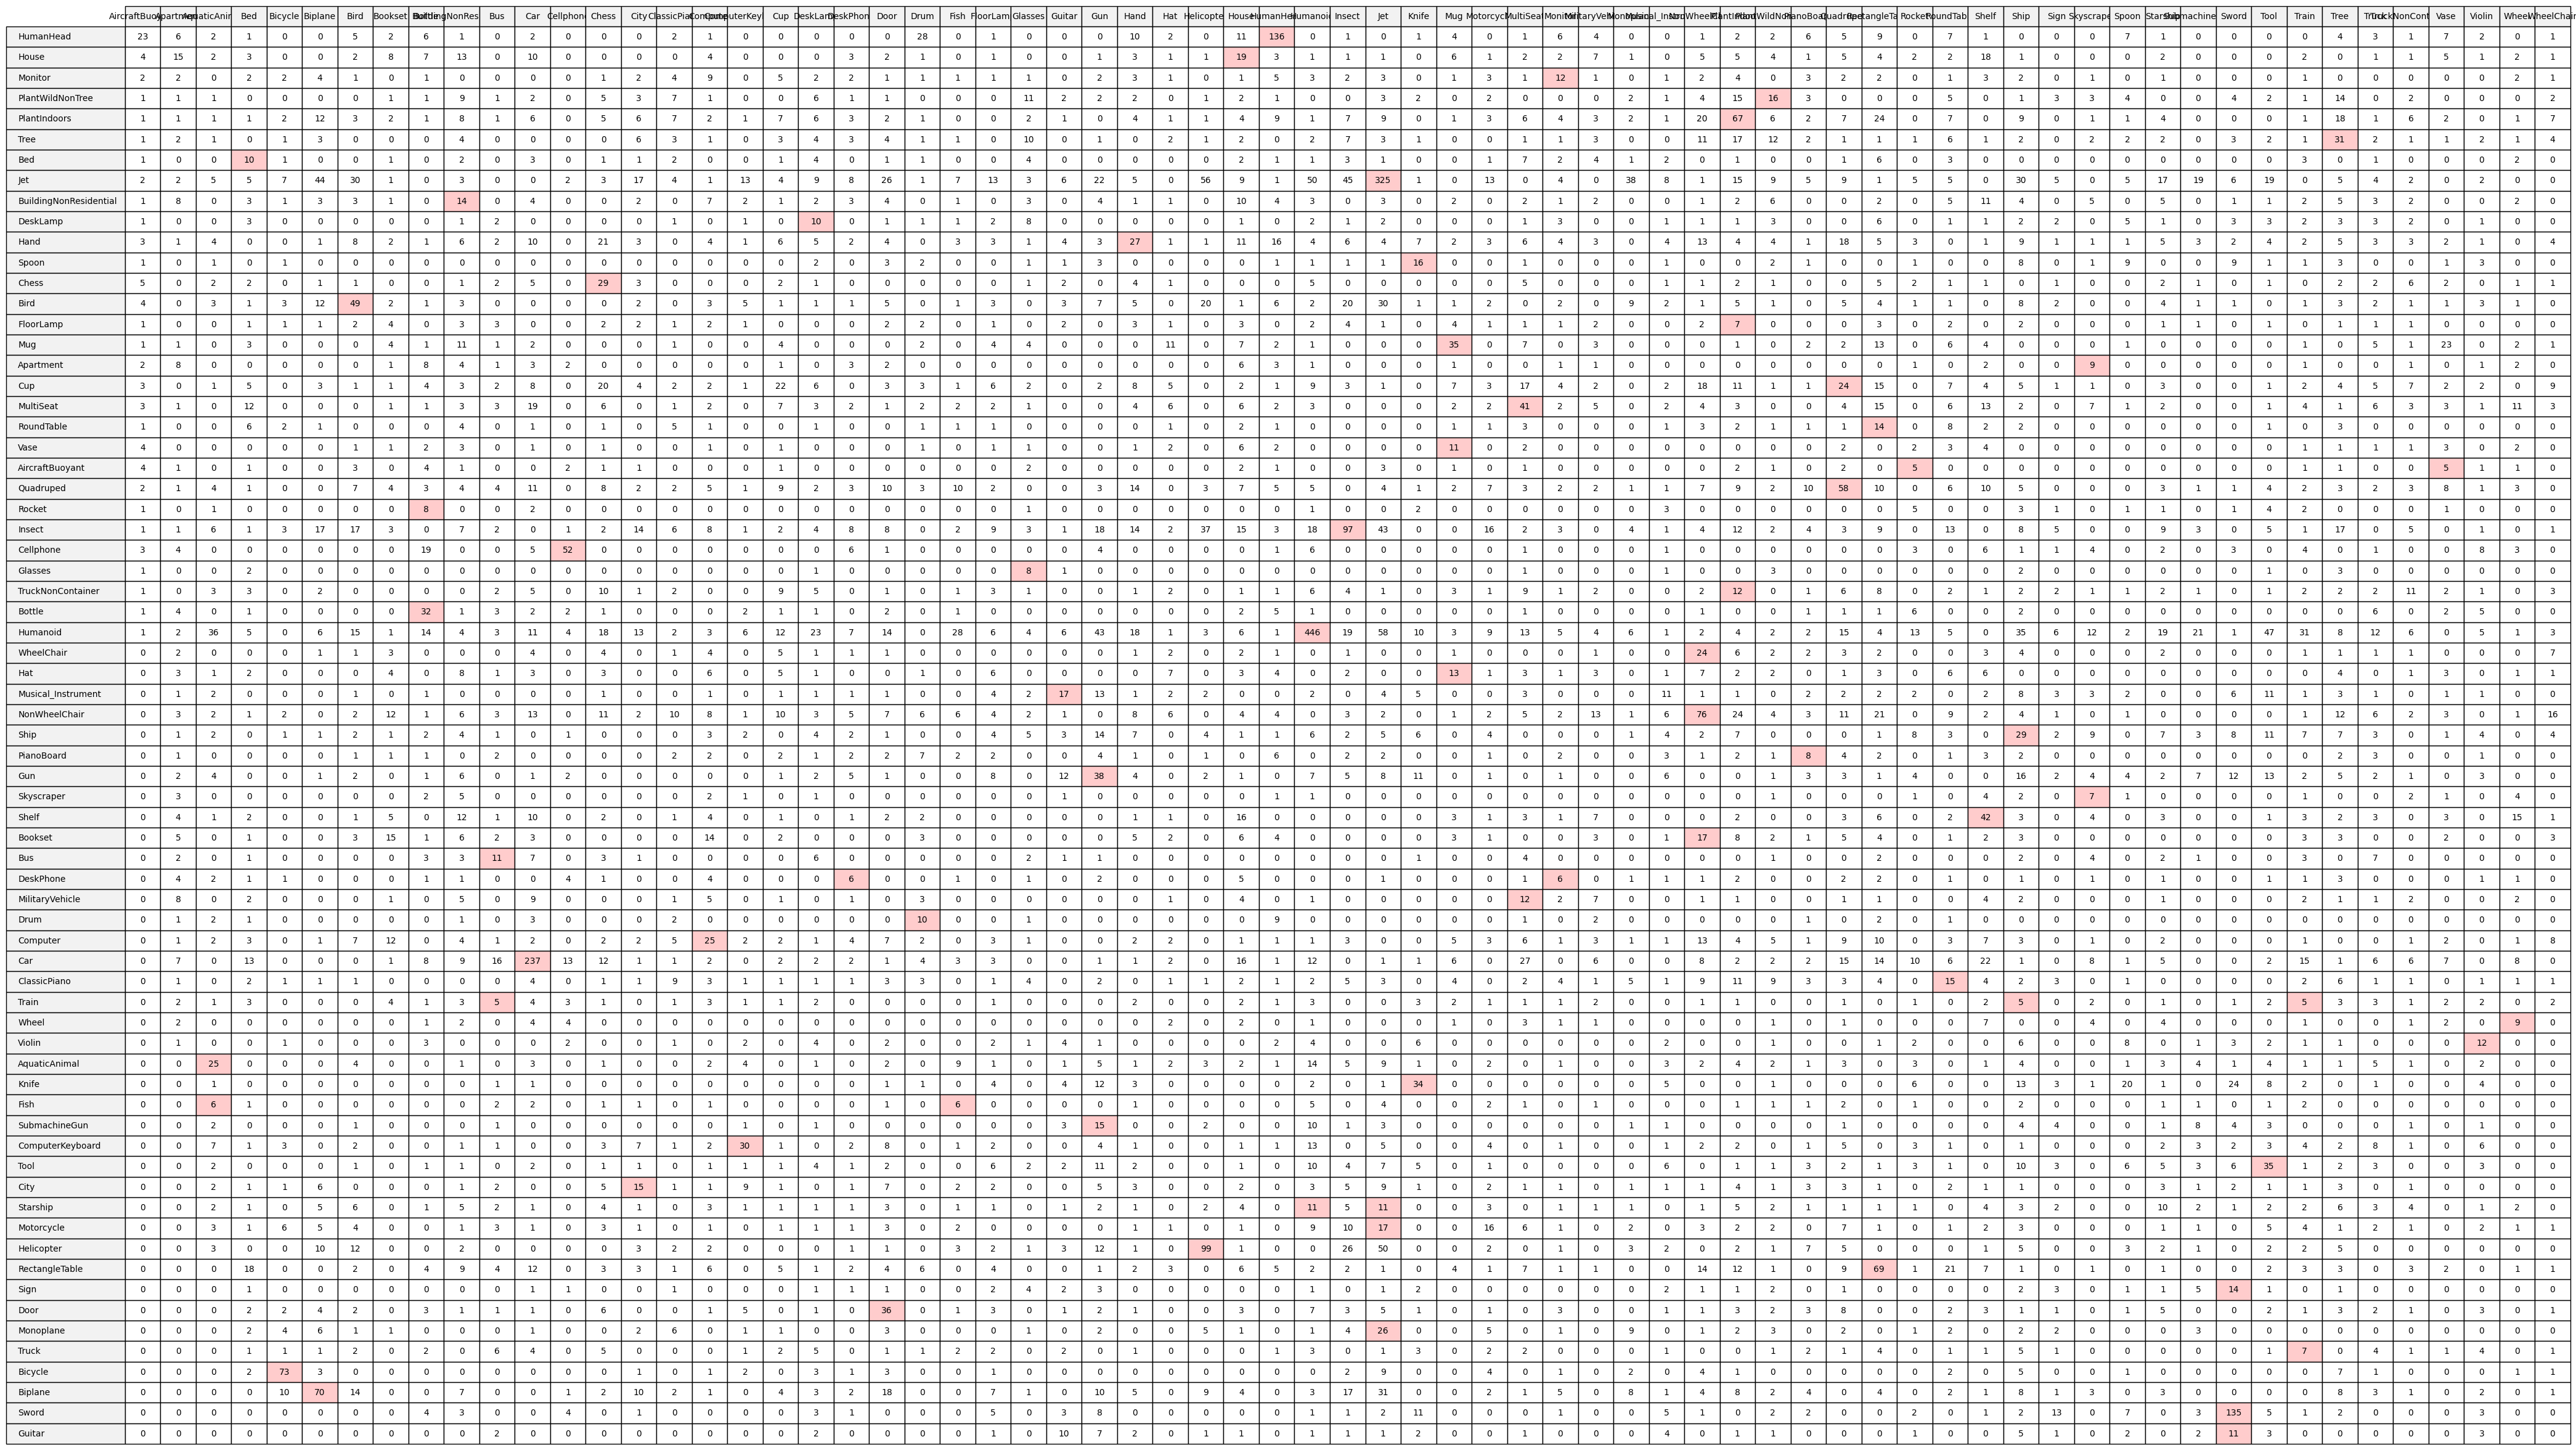

In [63]:
def visualize_counts_df(counts_df):
    fig, ax = plt.subplots()  # Set the figure size

    # Hide axes
    ax.xaxis.set_visible(False)
    ax.yaxis.set_visible(False)
    ax.set_frame_on(False)

    # Create a table
    table = ax.table(cellText=counts_df.values,
                     colLabels=counts_df.columns,
                     rowLabels=counts_df.index,
                     cellLoc='center',
                     loc='center',
                     colColours=['#f2f2f2']*counts_df.shape[1],
                     rowColours=['#f2f2f2']*counts_df.shape[0])

    table.auto_set_font_size(False)
    table.set_fontsize(10)
    table.scale(8, 2)  # Adjust the scale of the table
# Highlight the highest number in each row
    for i, row in enumerate(counts_df.values):
        max_val = np.max(row)
        for j, cell in enumerate(row):
            if cell == max_val:
                table[(i+1, j)].set_facecolor('#ffcccc')  # Highlight color

    plt.show()

# Example usage:
visualize_counts_df(counts_df)


               Unique Class              First Most  \
0      AircraftBuoyant (80)          HumanHead (23)   
1           Apartment (115)              House (15)   
2       AquaticAnimal (145)           Humanoid (36)   
3                 Bed (135)     RectangleTable (18)   
4             Bicycle (130)            Bicycle (73)   
..                      ...                     ...   
64  TruckNonContainer (100)  TruckNonContainer (11)   
65               Vase (100)                Mug (23)   
66             Violin (100)             Violin (12)   
67               Wheel (85)              Shelf (15)   
68          WheelChair (90)      NonWheelChair (16)   

                   Second Most            Third Most          Fourth Most  \
0                    Chess (5)             House (4)             Bird (4)   
1   BuildingNonResidential (8)         Apartment (8)  MilitaryVehicle (8)   
2           AquaticAnimal (25)  ComputerKeyboard (7)           Insect (6)   
3                     Car (13) 

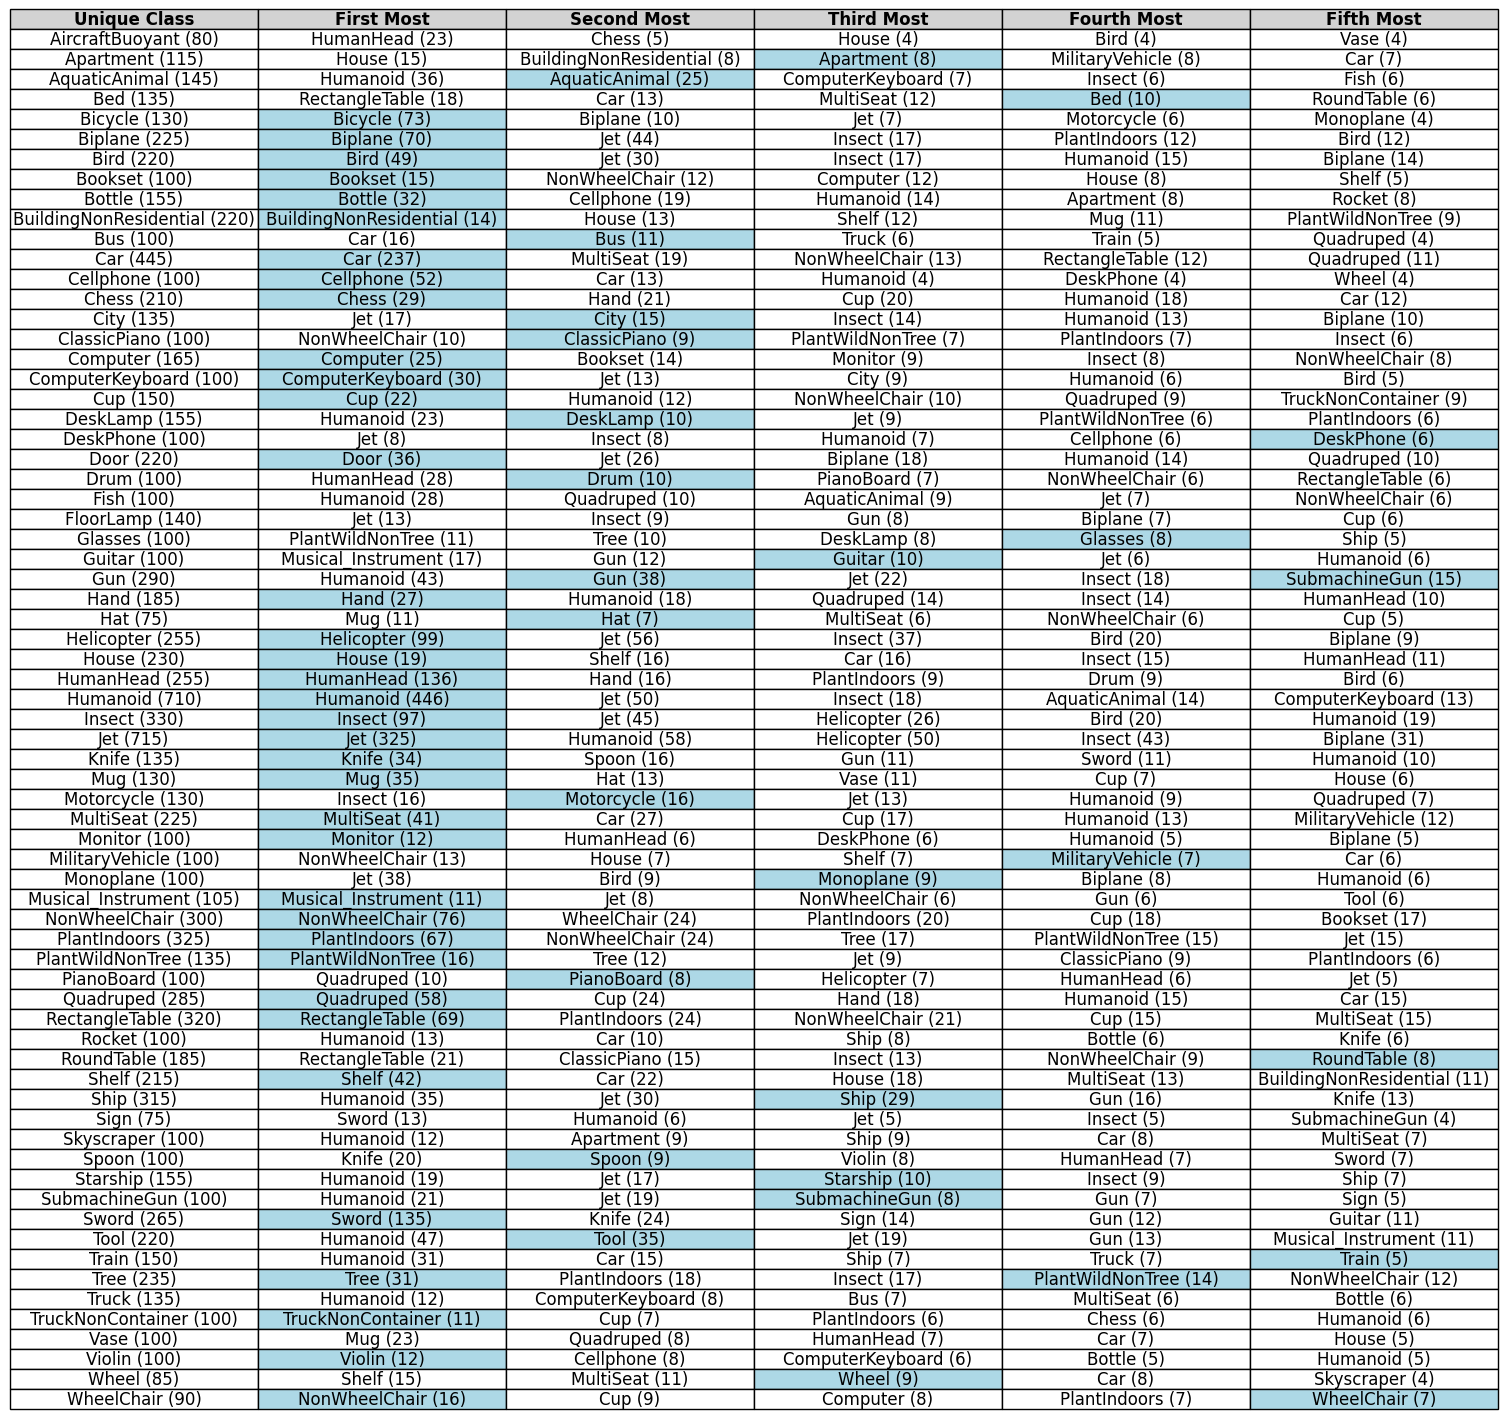

In [85]:
import pandas as pd

# Assuming counts_df is already available from the previous code

def get_top_5_classes_with_columns(counts_df):
    top_5_list = []

    # Iterate over each unique class in the counts_df
    for unique_class in counts_df.columns:
        # Get the counts for the current unique class
        class_counts = counts_df[unique_class]

        # Get the top 5 mentioned classes
        top_5_classes = class_counts.nlargest(5)

        # Create a dictionary to store the top 5 classes with their ranks
        top_5_dict = {
            'Unique Class': f"{ unique_class} ({int(class_counts.sum())})",
            'First Most': f"{top_5_classes.index[0]} ({top_5_classes.iloc[0]})" if len(top_5_classes) > 0 else None,
            'Second Most': f"{top_5_classes.index[1]} ({top_5_classes.iloc[1]})" if len(top_5_classes) > 1 else None,
            'Third Most': f"{top_5_classes.index[2]} ({top_5_classes.iloc[2]})" if len(top_5_classes) > 2 else None,
            'Fourth Most': f"{top_5_classes.index[3]} ({top_5_classes.iloc[3]})" if len(top_5_classes) > 3 else None,
            'Fifth Most': f"{top_5_classes.index[4]} ({top_5_classes.iloc[4]})" if len(top_5_classes) > 4 else None
        }

        # Append the dictionary to the list
        top_5_list.append(top_5_dict)

    # Convert the list to a DataFrame for better readability
    top_5_df = pd.DataFrame(top_5_list)

    return top_5_df

# Example usage:
# Assuming counts_df is already defined
top_5_df = get_top_5_classes_with_columns(counts_df)
print(top_5_df)


import matplotlib.pyplot as plt

# Function to visualize the top_5_df as a nice table with bold headers, light grey background, and light blue color for matching classes
def visualize_top_5_df_with_styling_and_highlight(top_5_df):
    fig, ax = plt.subplots()  # Set the figure size

    # Hide axes
    ax.xaxis.set_visible(False)
    ax.yaxis.set_visible(False)
    ax.set_frame_on(False)

    # Create a table
    table = ax.table(cellText=top_5_df.values,
                     colLabels=top_5_df.columns,
                     cellLoc='center',
                     loc='center')

    table.auto_set_font_size(False)
    table.set_fontsize(12)
    table.scale(3, 1.2)  # Adjust the scale of the table

    # Style the header
    for key, cell in table.get_celld().items():
        if key[0] == 0:  # Header row
            cell.set_text_props(weight='bold')  # Make header text bold
            cell.set_facecolor('#d3d3d3')  # Light grey background

    # Highlight the class that is the same as the unique class with light blue color
    for i, row in enumerate(top_5_df.values):
        unique_class = row[0].split(' (')[0]  # Extract the unique class name
        for j, cell in enumerate(row[1:], start=1):
            if unique_class in cell:
                table[(i+1, j)].set_facecolor('#add8e6')  # Light blue color

    plt.show()

# Example usage:
visualize_top_5_df_with_styling_and_highlight(top_5_df)





In [65]:
# Extracting the 'class' and 'neighbors' columns and saving them as tuples
everything = list(results[['class', 'neighbors']].itertuples(index=False, name=None))


[('AircraftBuoyant', [0, 0, 0, 0, 0]), ('AircraftBuoyant', [0, 0, 0, 0, 0]), ('AircraftBuoyant', [0, 0, 0, 0, 0]), ('AircraftBuoyant', [0, 0, 0, 0, 0]), ('AircraftBuoyant', [0, 0, 0, 0, 0]), ('AircraftBuoyant', [0, 0, 0, 0, 0]), ('AircraftBuoyant', [0, 0, 0, 0, 0]), ('AircraftBuoyant', [0, 0, 0, 0, 0]), ('AircraftBuoyant', [0, 0, 0, 0, 0]), ('AircraftBuoyant', [0, 1, 0, 0, 0]), ('AircraftBuoyant', [0, 1, 0, 0, 0]), ('AircraftBuoyant', [0, 0, 0, 0, 1]), ('AircraftBuoyant', [0, 1, 0, 0, 0]), ('AircraftBuoyant', [0, 0, 0, 0, 0]), ('AircraftBuoyant', [0, 0, 0, 0, 0]), ('AircraftBuoyant', [0, 0, 0, 0, 0]), ('Apartment', [0, 0, 0, 0, 0]), ('Apartment', [0, 0, 0, 0, 0]), ('Apartment', [0, 0, 0, 0, 0]), ('Apartment', [1, 0, 0, 0, 0]), ('Apartment', [0, 0, 0, 0, 0]), ('Apartment', [0, 0, 0, 0, 0]), ('Apartment', [0, 0, 0, 0, 0]), ('Apartment', [0, 0, 0, 0, 0]), ('Apartment', [0, 0, 0, 0, 0]), ('Apartment', [0, 0, 0, 0, 0]), ('Apartment', [0, 0, 1, 0, 0]), ('Apartment', [0, 0, 0, 0, 1]), ('Apart

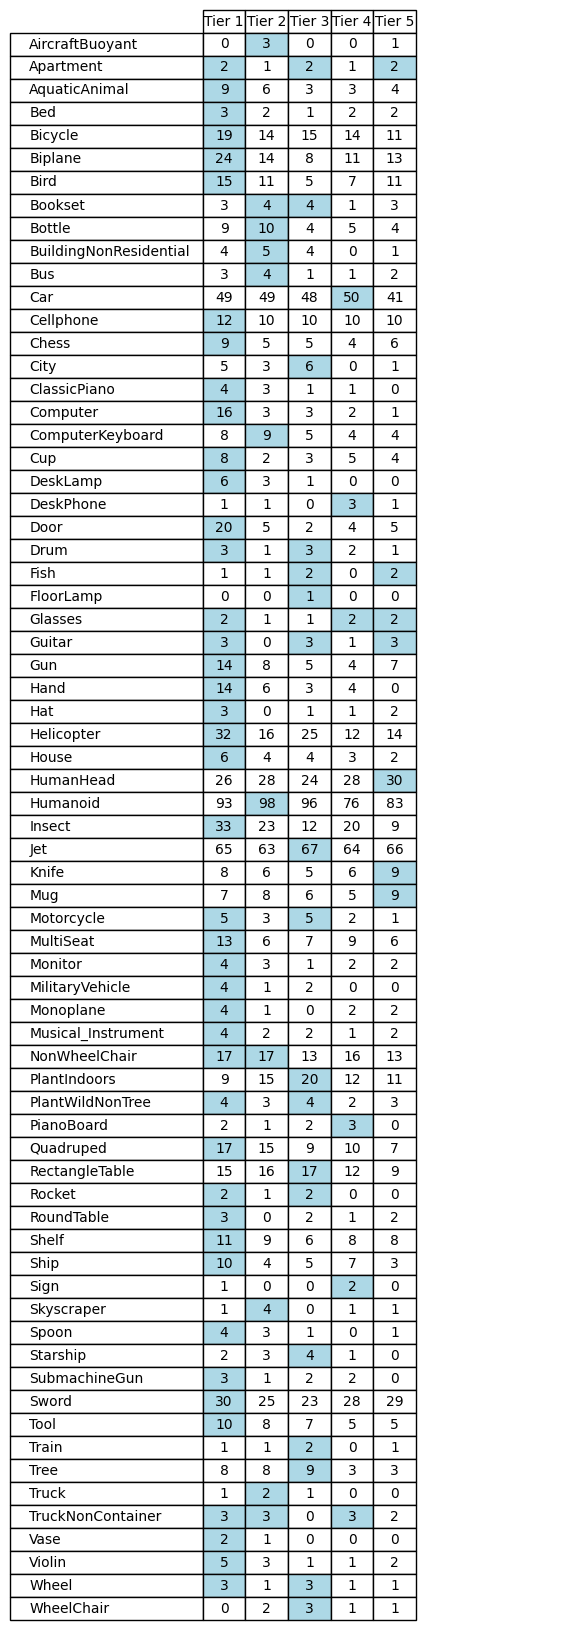

In [66]:
def transform_classnames(data):
    result = []
    for classname, classlist in data:
        transformed_list = [1 if item == classname else 0 for item in classlist]
        result.append((classname, transformed_list))
    return result

transformed_data = transform_classnames(everything)
print(transformed_data)

def flatten_and_sum(data):
    # Initialize a dictionary to store the sums for each unique classname
    classname_sums = {}
    
    for classname, classlist in data:
        if classname not in classname_sums:
            classname_sums[classname] = [0] * len(classlist)
        
        # Sum the values for each position
        classname_sums[classname] = [sum(x) for x in zip(classname_sums[classname], classlist)]
    
    # Convert the dictionary back to the desired format
    result = [(classname, sums) for classname, sums in classname_sums.items()]
    return result

# Example usage

flattened_data = flatten_and_sum(transformed_data)
print(flattened_data)
# Convert to DataFrame
df = pd.DataFrame(flattened_data, columns=['Classname', 'Tier Values'])

# Split the Tier Values into separate columns
df[['Tier 1', 'Tier 2', 'Tier 3', 'Tier 4', 'Tier 5']] = pd.DataFrame(df['Tier Values'].tolist(), index=df.index)

# Drop the original Tier Values column
df = df.drop(columns=['Tier Values'])

# Set the Classname as the index
df = df.set_index('Classname')
print(df['Tier 1'])
# Plot the table as an image using matplotlib
fig, ax = plt.subplots()  # Adjust the height based on the number of rows

ax.axis('tight')
ax.axis('off')
table = ax.table(cellText=df.values,
                 colLabels=df.columns,
                 rowLabels=df.index,
                 cellLoc='center',
                 loc='center')

# Highlight the highest number in each row with a light blue background
for i, row in enumerate(df.values):
    max_val = np.max(row)
    for j, val in enumerate(row):
        if val == max_val:
            table[(i+1, j)].set_facecolor('#ADD8E6')

table.auto_set_font_size(False)
table.set_fontsize(10)
table.scale(0.43, len(df) * 0.02)  # Adjust the scale based on the number of rows

plt.savefig("classnames_tiers_table.png", bbox_inches='tight')
plt.show()

[0.2592332  0.20823074 0.19064369 0.17270489 0.16918748]


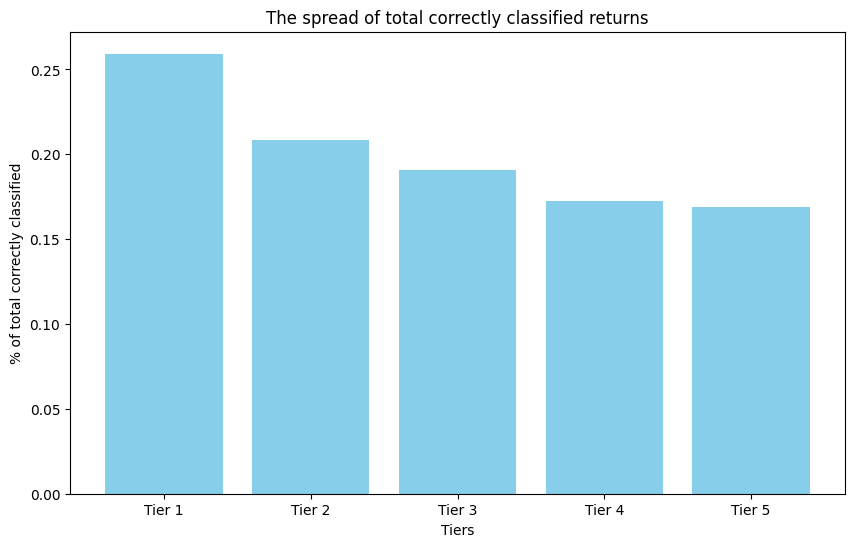

In [68]:
t1 = df['Tier 1'].sum()
t2 = df['Tier 2'].sum()
t3 = df['Tier 3'].sum()
t4 = df['Tier 4'].sum()
t5 = df['Tier 5'].sum()
countsTier = [t1, t2, t3, t4, t5]
total = sum(countsTier)
import matplotlib.pyplot as plt
import numpy as np

# Data provided by the user
data = countsTier/total

# X-axis labels
x_labels = ['Tier 1', 'Tier 2', 'Tier 3', 'Tier 4', 'Tier 5']

# Create the bar plot
plt.figure(figsize=(10, 6))
plt.bar(x_labels, data, color='skyblue')
print(data)

# Add labels and title
plt.xlabel('Tiers')
plt.ylabel('% of total correctly classified')
plt.title('The spread of total correctly classified returns')

# Display the plot
plt.show()